.....
----------------------------------------------------------------------
Ran 5 tests in 0.560s

OK



Confirmed Ideal Functions:
y36 is confirmed 
y11 is confirmed 
y2 is confirmed 
y33 is confirmed 

Final DataFrame:
  y_train y_train_ideal   min_sums
0      y1        y1_y36  33.711789
1      y2        y2_y11  32.628931
2      y3         y3_y2  33.118472
3      y4        y4_y33  31.752431

Metrics Results:
M36: 14243.738394013955
M11: 14223.330188652817
M2: 10093.997435862766
M33: 7147.594853359049
N36_max: 14341.809945231615
N11_max: 14451.902043652097
N2_max: 9961.633256939205
N33_max: 6414.6410038341155


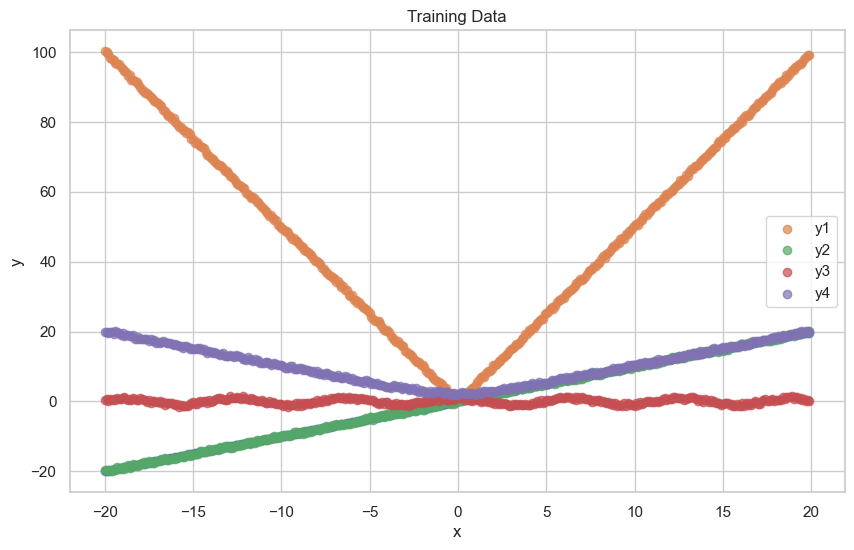

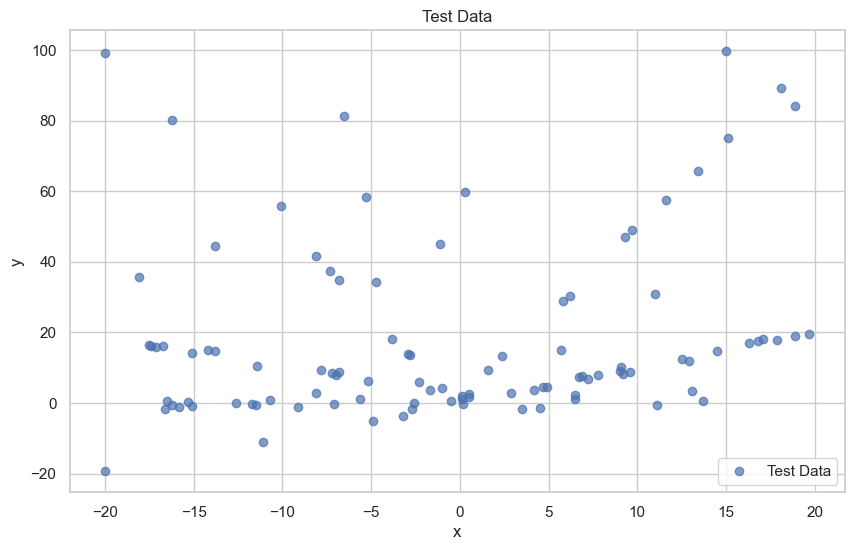

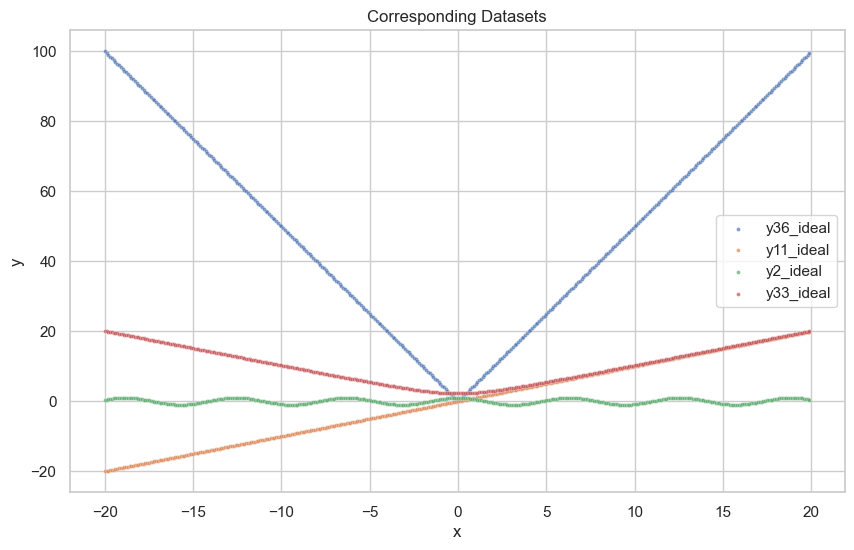

In [5]:
# Data Loading and Preparation

import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Connect to SQLite database and create tables
engine = create_engine('sqlite:///mydatabase.db')
connection = engine.connect()

# Load training, ideal, and test data from CSV files
training_data = pd.read_csv('train.csv')
ideal_functions = pd.read_csv('ideal.csv')
test_data = pd.read_csv('test.csv')
test_data = test_data.sort_values(by="x")

# Write the data to the SQLite database
training_data.to_sql('training_data', con=connection, index=False, if_exists='replace')
ideal_functions.to_sql('ideal_functions', con=connection, index=False, if_exists='replace')



class DataFrameOperation:
    """
    Class to perform operations on DataFrames and calculate summaries.
    """

    def __init__(self, train_df, ideal_df, test_df):
        """
        Initializes the DataFrameOperation instance.

        Parameters:
            train_df (pd.DataFrame): The training DataFrame.
            ideal_df (pd.DataFrame): The ideal DataFrame.
            test_df (pd.DataFrame): The test DataFrame.
        """
        self.train_df = train_df
        self.ideal_df = ideal_df
        self.test_df = test_df
        self.result_dataframes = {}  # Dictionary to store resulting DataFrames

    def perform_operations(self):
        """
        Performs operations between columns of train_df and ideal_df (quadratic deviation of y values between each training set and ideal function).
        """
        for col_train in self.train_df.columns:
            new_dataframe = pd.DataFrame()
            for col_ideal in self.ideal_df.columns:
                new_column = f"{col_train}_{col_ideal}"
                new_dataframe[new_column] = (self.ideal_df[col_ideal] - self.train_df[col_train])**2

            # Store the resulting DataFrame in the dictionary
            self.result_dataframes[col_train] = new_dataframe

    def calculate_sum(self):
        """
        Calculates the sum of each column in the new DataFrame.

        Returns:
            dict: A dictionary with column names as keys and corresponding sum DataFrames as values.
        """
        sum_dataframes = {}
        for col_train, dataframe in self.result_dataframes.items():
            sum_of_column = dataframe.sum()
            sum_dataframes[col_train] = pd.DataFrame({'sum': sum_of_column})

        return sum_dataframes

    def find_min_sum(self):
        """
        Finds the column index with the smallest sum for each column.

        Returns:
            dict: A dictionary with column names as keys and corresponding index of minimum sum as values.
        """
        min_sums = {}
        for col_train, dataframe in self.result_dataframes.items():
            min_sums[col_train] = dataframe.sum().idxmin()

        return min_sums

    # y36, y11, y2, and y33 are respectively the four ideal functions found based on
    # the above find_min_sum() method

    
    # Calculate metrics (M and N)
    # M: Max. deviation between (one) ideal function and test data set
    # N: Max. deviation between all 4 training data and the corresponding ideal functions
    
    def calculate_metrics(self, test_data, training_data, ideals):
        """
        Calculates M and N values based on the provided formulas.

        Returns:
            dict: A dictionary with M and N values for each metric.
        """
        # Ideal functions corresponding to the training data sets
        ideals = ideal_functions[['x', 'y36', 'y11', 'y2', 'y33']]

        # Merge test_df and ideal_df on column "x"
        test_ideal = pd.merge(test_data, ideals, on="x", how="inner")

        # Merge train_df and ideal_df on column "x"
        train_ideal = pd.merge(training_data, ideals, on="x", how="inner")

        # Rename columns
        train_ideal.rename(columns={
            'y2_x': 'y2_train',
            'y2_y': 'y2_ideal',
            'y1': 'y1_train',
            'y3': 'y3_train',
            'y4': 'y4_train',
            'y36': 'y36_ideal',
            'y11': 'y11_ideal',
            'y33': 'y33_ideal'
        }, inplace=True)

        
        fits = ['y36', 'y11', 'y2', 'y33']

        # Calculate M36, M11, M2, M33 corresponding to the four ideal functions
        M_values = {f'M{fit[1:]}': ((test_ideal[fit] - test_ideal["y"]) ** 2).max() for fit in fits}

        # Choose N_max for each ideal function
        N_max_values = {
            f'N{fit[1:]}_max': max(
                ((train_ideal[f'{fit}_ideal'] - train_ideal[f"y{i}_train"]) ** 2).max() for i in range(1, 5)
            )
            for fit in fits
        }
       
        # Save these different calculated metrics in a single dictionary
        result_dict = {**M_values, **N_max_values}

        return result_dict

    

    # Visualization of training data, the test data, the selected ideal functions, and the corresponding/assigned data sets    
    def plot_data(self, train_df, test_df, ideals_df):
        """
        Plot the training data, test data, ideal functions, and corresponding datasets.

        Parameters:
            train_df (pd.DataFrame): Training DataFrame.
            test_df (pd.DataFrame): Test DataFrame.
            ideals_df (pd.DataFrame): Ideal functions DataFrame.
        """
        # Matplotlib plot for training data
        plt.figure(figsize=(10, 6))
        for col in training_data.columns:
            plt.scatter(training_data['x'], training_data[col], label=col if col != 'x' else None, alpha=0.7)
        plt.title("Training Data")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

        # Matplotlib plot for test data
        plt.figure(figsize=(10, 6))
        plt.scatter(test_data['x'], test_data['y'], label="Test Data", alpha=0.7)
        plt.title("Test Data")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()


        
        
        # Seaborn plot for corresponding ideal functions
        # Create a style for the Seaborn plot (optional)
        sns.set(style="whitegrid")
        
        # Create a new scatter plot using Seaborn
        plt.figure(figsize=(10, 6))
        for i, col in enumerate(ideals.columns[1:]):
            sns.scatterplot(x='x', y=col, data=ideals, label=f"{col}_ideal", alpha=0.7, s=8)
        
        # Add labels and legend to the plot
        plt.title("Corresponding Datasets")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        
        # Show the plot
        plt.show()



    def display_results(self, sum_dataframes, min_sums_dataframe, metrics_result):
        """
        Display the results of the calculations.

        Parameters:
            sum_dataframes (dict): A dictionary with column names as keys and corresponding sum DataFrames as values.
            min_sums_dataframe (pd.DataFrame): DataFrame with the indices of ideal_df columns and corresponding minimum sums.
            metrics_result (dict): A dictionary with M and N values for each metric.
        """

        # Display the final DataFrame from minimization of the sum of all y-squared deviations (least-square)
        print("\nFinal DataFrame:")
        print(min_sums_dataframe)

        # Display the results of the calculated metrics
        print("\nMetrics Results:")
        for metric, value in metrics_result.items():
            print(f"{metric}: {value}")
        
        # Plot the training data, test data, ideal functions, and corresponding datasets
        self.plot_data(self.train_df, self.test_df, self.ideal_df)




# Set global variables for the second class to confirm the four corresponding ideal functions

# corresponding ideal functions dataframe 
ideals = ideal_functions[['x', 'y36', 'y11', 'y2', 'y33']]
# Merge test and ideal dataframes
test_ideal = pd.merge(test_data, ideals, on="x", how="inner")
# Merge training and ideal dataframes
train_ideal = pd.merge(training_data, ideals, on="x", how="inner")
# Rename columns in train_ideal dataframe
train_ideal.rename(columns={
    'y2_x': 'y2_train',
    'y2_y': 'y2_ideal',
    'y1': 'y1_train',
    'y3': 'y3_train',
    'y4': 'y4_train',
    'y36': 'y36_ideal',
    'y11': 'y11_ideal',
    'y33': 'y33_ideal'
}, inplace=True)

class EnhancedDataFrameOperation(DataFrameOperation):
    def __init__(self, train_df, ideal_df, test_df):
        super().__init__(train_df, ideal_df, test_df)

    def confirm_ideal_functions(self, metrics_result):
        """
        Confirm ideal functions based on specified conditions.

        Parameters:
            metrics_result (dict): A dictionary with M and N values for each metric.

        Returns:
            dict: A dictionary with confirmed ideal functions.
        """
        confirmed_ideals = {}

        for metric, M_value in metrics_result.items():
            metric_number = metric[1:]
            N_max_key = f'N{metric_number}_max'
            threshold = np.sqrt(2) * metrics_result.get(N_max_key, 0)

            if M_value < threshold:
                col_train = f'y{metric_number}'
                col_ideal_index = f'y{metric_number}_{metric_number}'
                confirmed_ideals[col_train] = col_ideal_index

        return confirmed_ideals

    def set_results(self, sum_dataframes, min_sums_dataframe, metrics_result):
        """
        Set the calculated results to the instance.

        Parameters:
            sum_dataframes (dict): A dictionary with column names as keys and corresponding sum DataFrames as values.
            min_sums_dataframe (pd.DataFrame): DataFrame with the indices of ideal_df columns and corresponding minimum sums.
            metrics_result (dict): A dictionary with M and N values for each metric.
        """
        self.sum_dataframes = sum_dataframes
        self.min_sums_dataframe = min_sums_dataframe
        self.metrics_result = metrics_result

    def display_results(self):
        """
        Display the results of the calculations and visualizations.
        """
        super().display_results(self.sum_dataframes, self.min_sums_dataframe, self.metrics_result)


# Test our code with Unittest: to verify the program's functionality
import unittest

class TestEnhancedDataFrameOperation(unittest.TestCase):

    def setUp(self):
        # Load dataframes
        self.training_data = pd.read_csv('train.csv')
        self.ideal_functions = pd.read_csv('ideal.csv')
        self.test_data = pd.read_csv('test.csv')
        self.test_data = self.test_data.sort_values(by="x")

        # Create necessary instances
        self.data_frame_operation = EnhancedDataFrameOperation(self.training_data, self.ideal_functions, self.test_data)

    def test_perform_operations(self):
        # Test the perform_operations method
        self.data_frame_operation.perform_operations()
        self.assertNotEqual(len(self.data_frame_operation.result_dataframes), 0)

    def test_calculate_sum(self):
        # Test the calculate_sum method
        self.data_frame_operation.perform_operations()
        sum_dataframes = self.data_frame_operation.calculate_sum()
        self.assertFalse(all(df.empty for df in sum_dataframes.values()))

    def test_find_min_sum(self):
        # Test the find_min_sum method
        self.data_frame_operation.perform_operations()
        min_sums = self.data_frame_operation.find_min_sum()
        self.assertNotEqual(len(min_sums), 0)

    def test_calculate_metrics(self):
        # Test the calculate_metrics method
        metrics_result = self.data_frame_operation.calculate_metrics(self.test_data, self.training_data, self.ideal_functions)
        self.assertTrue(all(isinstance(value, (int, float)) for value in metrics_result.values()))

    def test_confirm_ideal_functions(self):
        # Test the confirm_ideal_functions method
        self.data_frame_operation.perform_operations()
        metrics_result = self.data_frame_operation.calculate_metrics(self.test_data, self.training_data, self.ideal_functions)
        confirmed_ideals = self.data_frame_operation.confirm_ideal_functions(metrics_result)
        self.assertNotEqual(len(confirmed_ideals), 0)


'''since we are working on jupyter Notebook, it's important to note that using 
if __name__ == '__main__':
    unittest.main()
will return an error, and even when we create a separate script for the test, importing the script to be tested won't work!!!'''
# solution to solve the problem so we can test the code:
# Create a TestLoader and TestSuite
loader = unittest.TestLoader()
suite = loader.loadTestsFromTestCase(TestEnhancedDataFrameOperation)

# Create a TestRunner and run the tests
runner = unittest.TextTestRunner()
result = runner.run(suite)



# Calculate squared differences (Delta) between 'y' values from the test dataset and each corresponding 'y' from 
# the ideal functions, creating Delta columns for each comparison.
test_ideal['Delta y_y36'] = (test_ideal['y'] - test_ideal['y36'])**2
test_ideal['Delta y_y11'] = (test_ideal['y'] - test_ideal['y11'])**2
test_ideal['Delta y_y2'] = (test_ideal['y'] - test_ideal['y2'])**2
test_ideal['Delta y_y33'] = (test_ideal['y'] - test_ideal['y33'])**2


def save_tables_to_database(engine, test_ideal):
    # Define tables and corresponding columns for each comparison
    tables_columns = {
        'table_1': ['x', 'y', 'Delta y_y36', 'y36'],
        'table_2': ['x', 'y', 'Delta y_y11', 'y11'],
        'table_3': ['x', 'y', 'Delta y_y2', 'y2'],
        'table_4': ['x', 'y', 'Delta y_y33', 'y33']
    }

    # Save DataFrames to individual tables in the database
    for table_name, columns in tables_columns.items():
        df = test_ideal[columns]
        df.to_sql(table_name, con=engine, index=False, if_exists='replace')

# Call the function with the test_ideal DataFrame
save_tables_to_database(engine, test_ideal)



def main():
    try:
         # This function serves as the main entry point for the script.
        # It performs various operations on dataframes and displays the results.

        # Select 'y' columns from 'train' and 'ideal'
        train_df = training_data.iloc[:, 1:]
        ideal_df = ideal_functions.iloc[:, 1:]

        # Create an instance of the EnhancedDataFrameOperation class
        column_operation_instance = EnhancedDataFrameOperation(train_df, ideal_df, test_data)

        # Perform operations between columns
        column_operation_instance.perform_operations()

        # Calculate the sum of each column in the new DataFrame
        sum_dataframes = column_operation_instance.calculate_sum()

        # Find the column index with the smallest sum for each column
        min_sums = column_operation_instance.find_min_sum()

        # Create a DataFrame grouping the minimum sums with the indices of ideal_df columns
        min_sums_dataframe = pd.DataFrame(min_sums.items(), columns=['y_train', 'y_train_ideal'])

        # Add a column of sums to the DataFrame
        min_sums_dataframe['min_sums'] = min_sums_dataframe['y_train'].apply(
            lambda x: sum_dataframes[x]['sum'].min()
        )

        # Calculate metrics and display the results from task 2
        metrics_result = column_operation_instance.calculate_metrics(test_data, training_data, ideals)

        # Confirm ideal functions
        confirmed_ideals = column_operation_instance.confirm_ideal_functions(metrics_result)

        # Display the confirmed ideal functions
        print("\nConfirmed Ideal Functions:")
        for col_train, col_ideal_index in confirmed_ideals.items():
            print(f"{col_train} is confirmed ")

        # Set the calculated results and visualizations to the instance
        column_operation_instance.set_results(sum_dataframes, min_sums_dataframe, metrics_result)

        # Display the results and visualizations
        column_operation_instance.display_results()
        
    # Handle the case where a FileNotFoundError occurs, typically due to missing input files.
    except FileNotFoundError as e:
        print(f"Error: {e}")
    
    # Handle unexpected errors by catching any Exception.
    except Exception as ex:
        print(f"An unexpected error occurred: {ex}")


# Check if this script is the main entry point for execution.
if __name__ == "__main__":
    # If the script is being run directly, execute the main() function.
    main()







